In [1]:
import glob
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
df = pd.read_csv('../input/best-artworks-of-all-time/artists.csv')
df = df.drop(columns=['bio', 'wikipedia'])

In [3]:
artists_hist_dict = {}
for ii in glob.glob('../input/best-artworks-of-all-time/images/images/*'):
    blue_hist = []
    red_hist = []
    green_hist = []
    for j in glob.glob(ii + '/*'):
        img = cv2.imread(j)
        for i, col in enumerate(['b', 'g', 'r']):
            hist = cv2.calcHist([img], [i], None, [256], [0, 256])
            if col=='b':
                blue_hist.append(hist)
            elif col=='g':
                green_hist.append(hist)
            elif col=='r':
                red_hist.append(hist)

    blue_hist = sum(blue_hist)/len(blue_hist)
    green_hist = sum(green_hist)/len(green_hist)
    red_hist = sum(red_hist)/len(red_hist)
    artists_hist_dict[j.split('/')[-2]] = [blue_hist, green_hist, red_hist]

In [22]:
equivalent_artists = []
for i in artists_hist_dict:
    score_max = 0
    for j in artists_hist_dict:
        score = 0
        if i!=j:
            for k,l in zip(artists_hist_dict[j], artists_hist_dict[i]):     
                score = score + cv2.compareHist(k, l, cv2.HISTCMP_CORREL)
                score = score/3.0
            if score > score_max:
                score_max = score
                similar_artist = j
    equivalent_artists.append((i,similar_artist, score_max))

In [56]:
def plot(artist_1,  artist_2, title_of_plot):
    blue_hist1, green_hist1, red_hist1 = artists_hist_dict[artist_1]
    blue_hist2, green_hist2, red_hist2 = artists_hist_dict[artist_2]
    fig, axs = plt.subplots(2,figsize=(5,5))
    fig.tight_layout()
    fig.suptitle('score :' + title_of_plot )
    axs[0].title.set_text(artist_1)
    axs[0].plot(blue_hist1, color = 'b')
    axs[0].plot(green_hist1, color = 'g')
    axs[0].plot(red_hist1, color = 'r')
    axs[1].title.set_text(artist_2)
    axs[1].plot(blue_hist2, color = 'b')
    axs[1].plot(green_hist2, color = 'g')
    axs[1].plot(red_hist2, color = 'r')

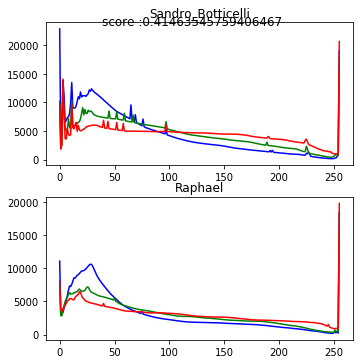

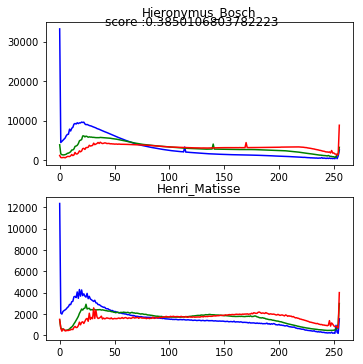

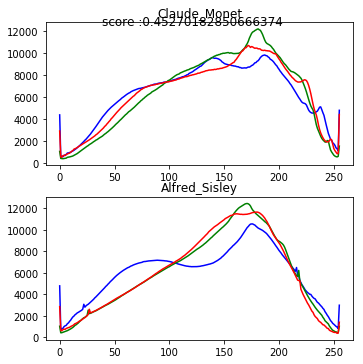

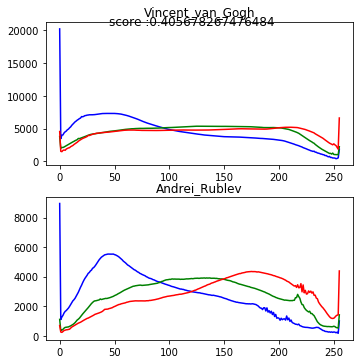

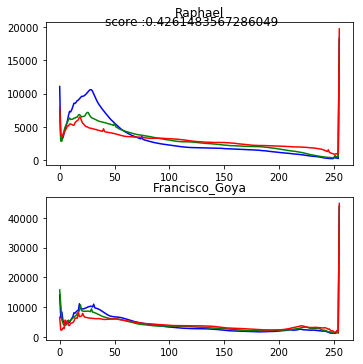

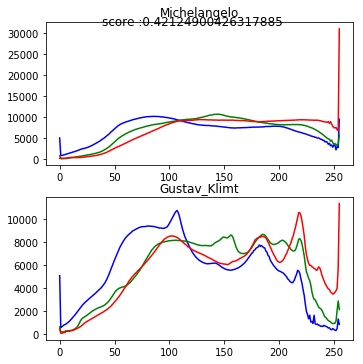

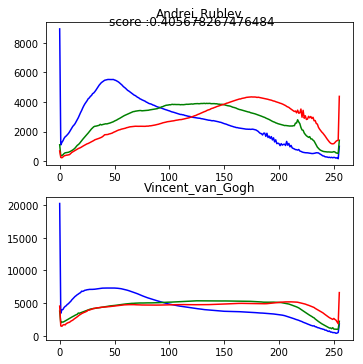

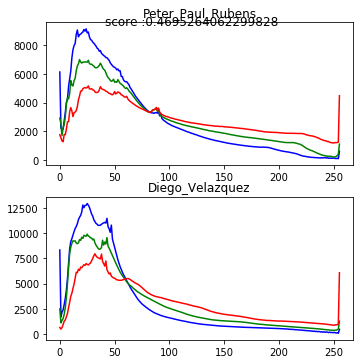

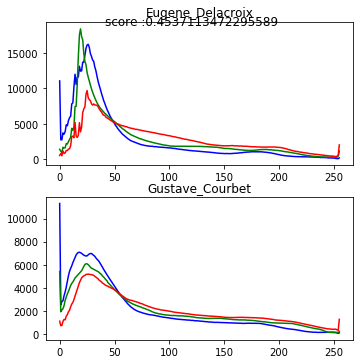

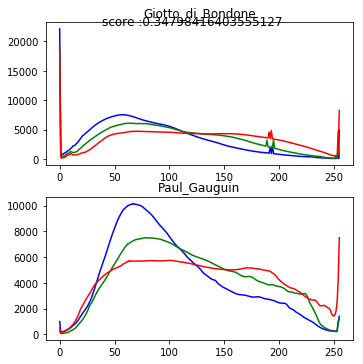

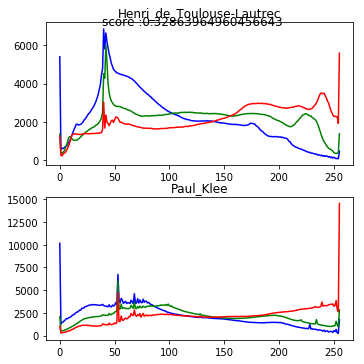

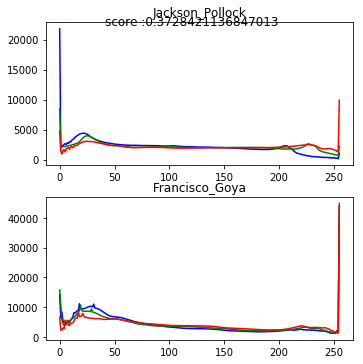

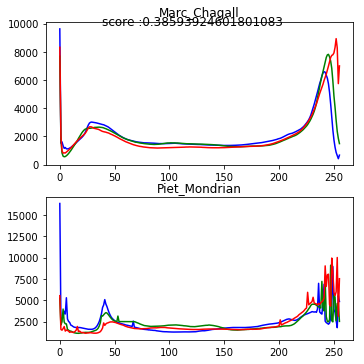

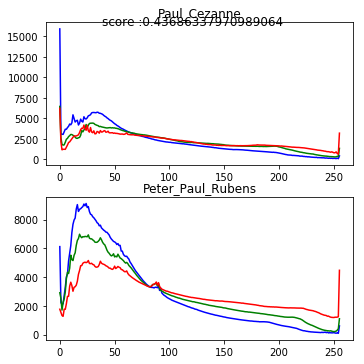

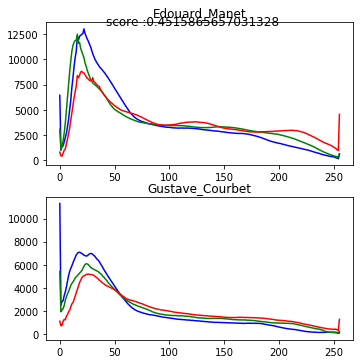

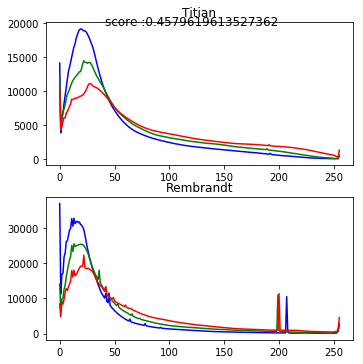

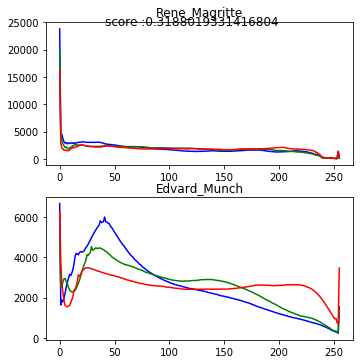

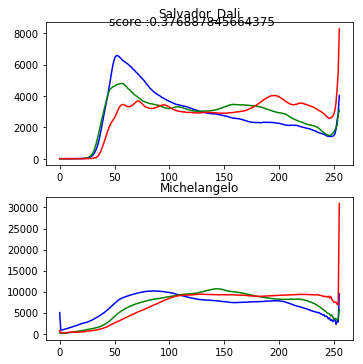

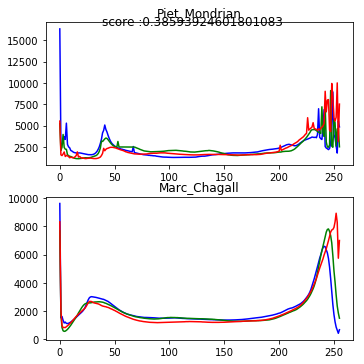

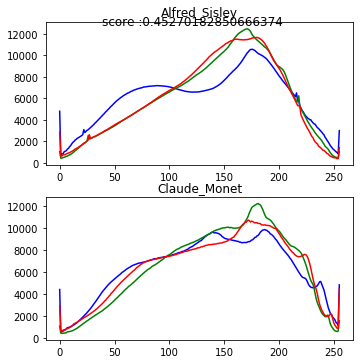

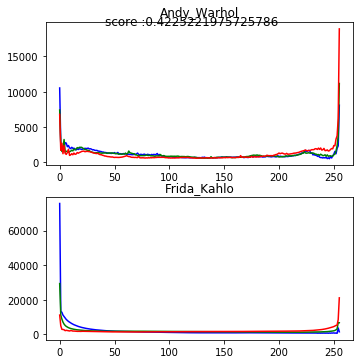

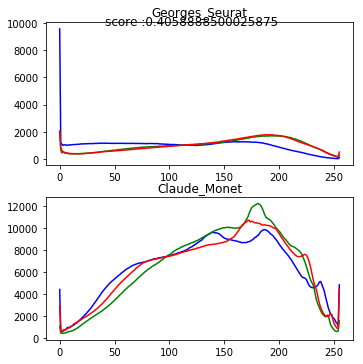

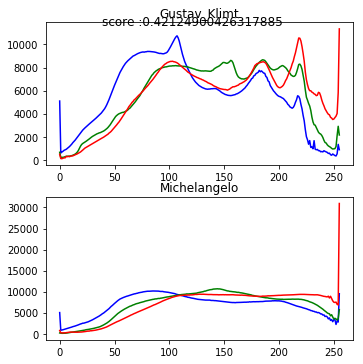

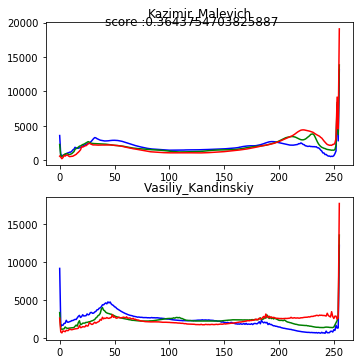

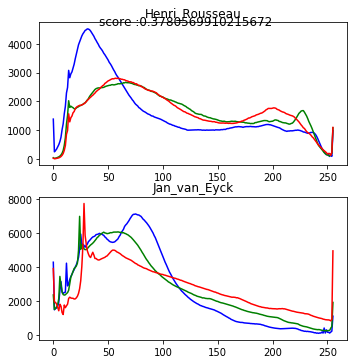

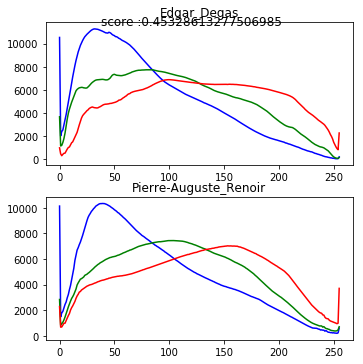

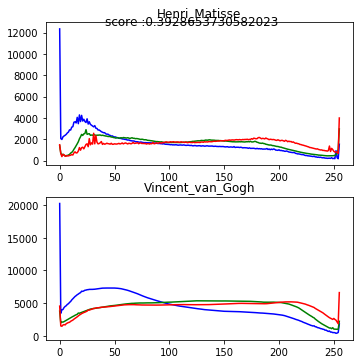

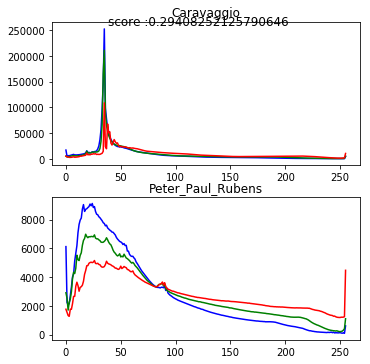

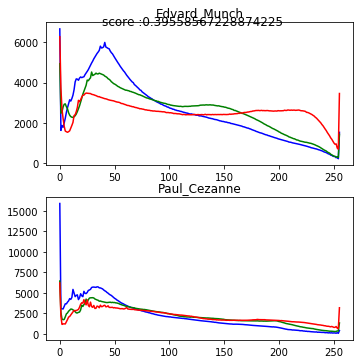

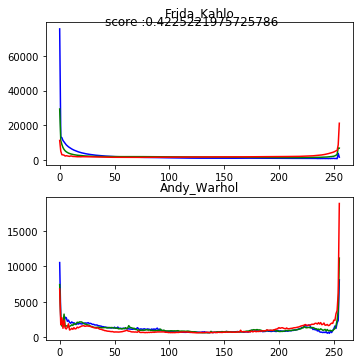

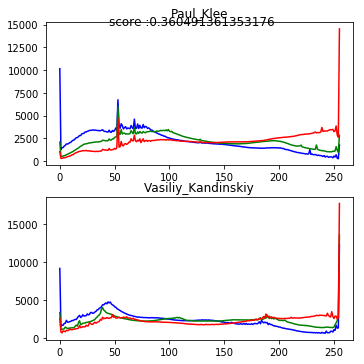

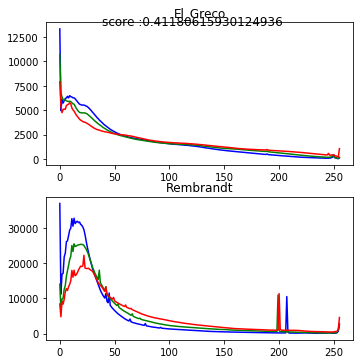

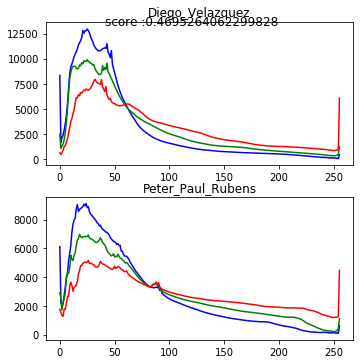

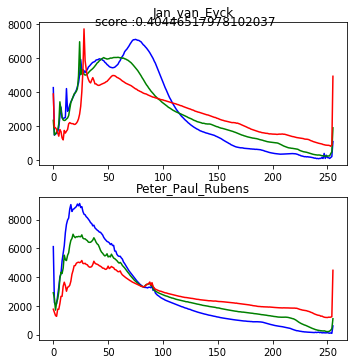

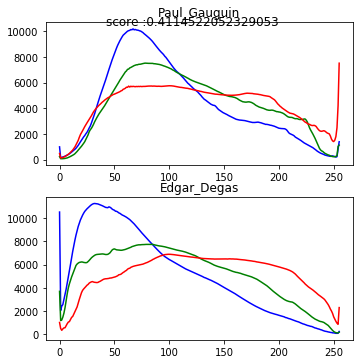

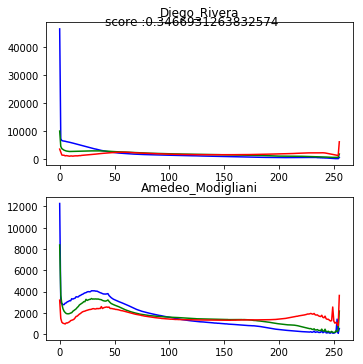

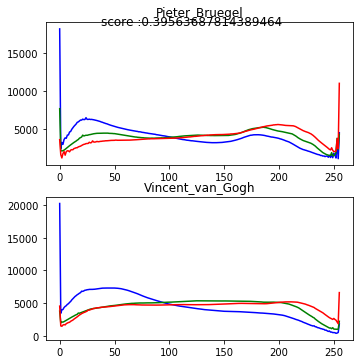

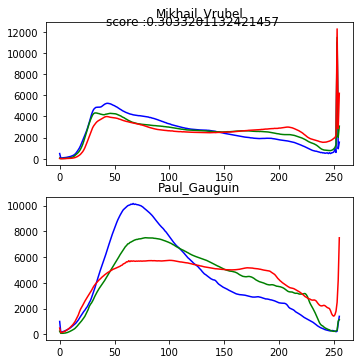

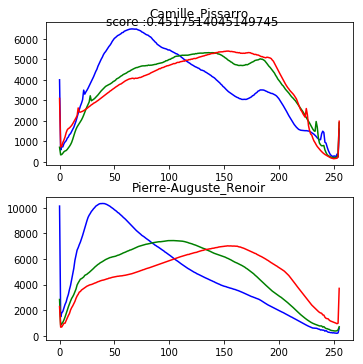

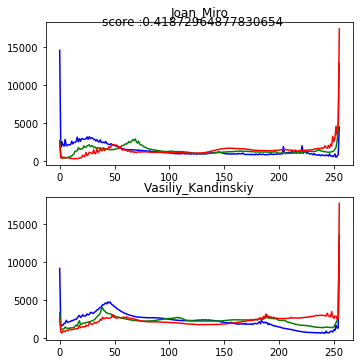

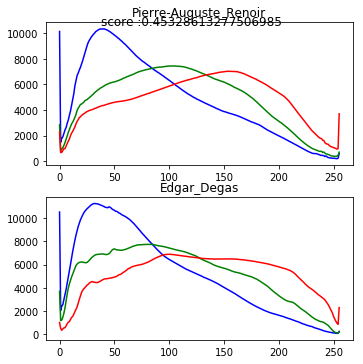

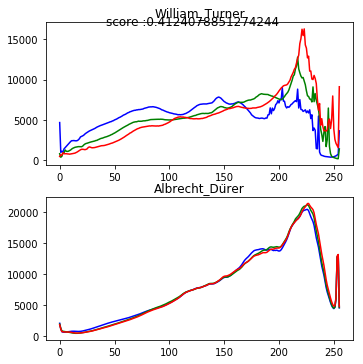

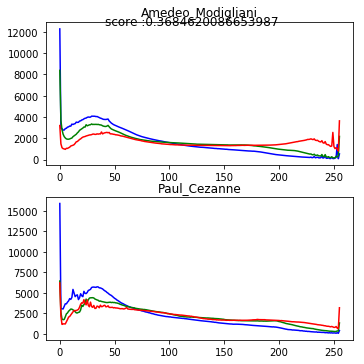

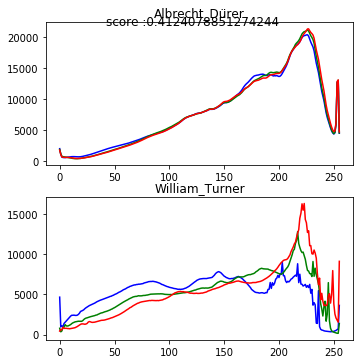

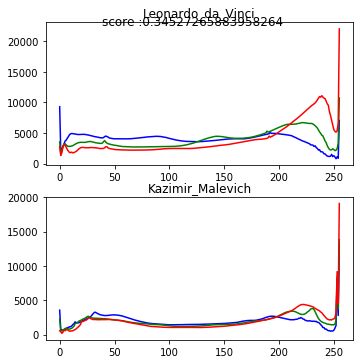

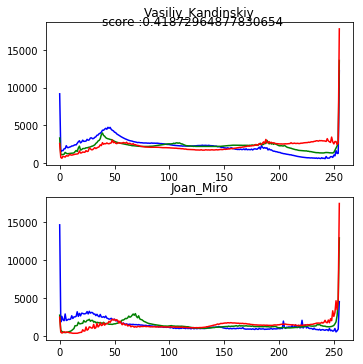

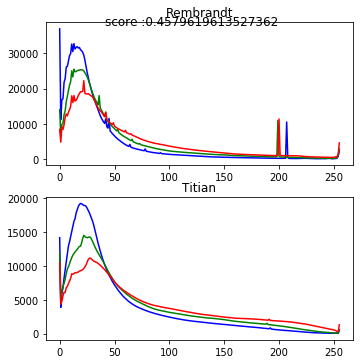

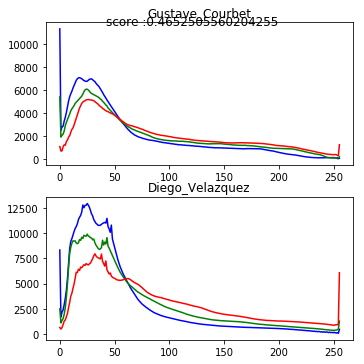

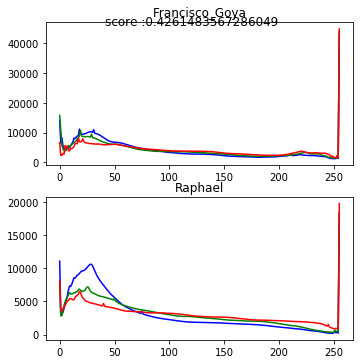

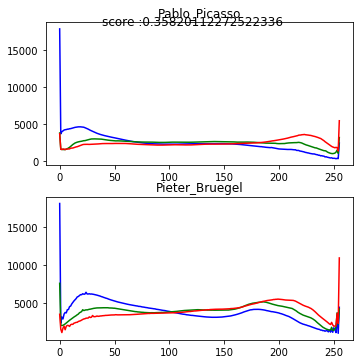

In [57]:
for i in equivalent_artists:
    plot(i[0], i[1], str(i[2]))